In [1]:
import os
import urllib
import cv2
import numpy as np

from skimage.transform import resize
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### 인물 사진

(512, 512, 3)


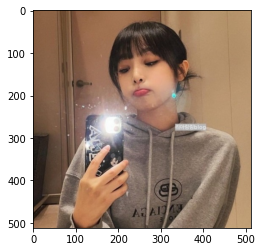

In [2]:
# 이미지 로드
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일명 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f934c533160>)

In [4]:
# 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델 이미지 입력 - pascal voc 데이터로 학습된 모델을 이용함
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
# PASCAL VOC의 데이터 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

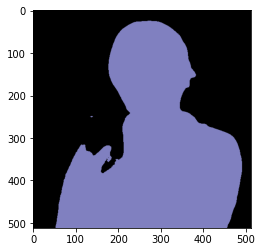

In [7]:
plt.imshow(output)
plt.show()

In [8]:
# class_ids, masks 확인
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

class_ids가 15, 즉 person을 가리키고 있음을 알 수 있다.

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 물체마다 output에서 어떤 색상이 나타나 있는지 출력
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 사람을 나타내는 색상 확인
colormap[15]

array([192, 128, 128])

In [12]:
# 색상이 BGR의 순서로 배치되어 있으므로 순서를 바꿔준다.
seg_color = (128,128,192)

(512, 512)


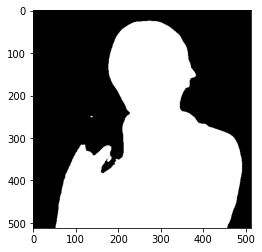

In [13]:
# seg_color로 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됨
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

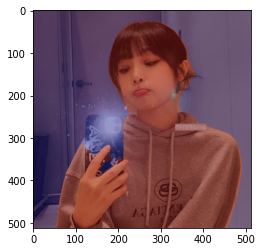

In [14]:
# 원래 이미지와 겹쳐 세그멘테이션을 확인
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 결합
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

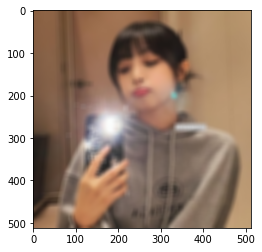

In [15]:
# 배경을 흐리게 변경
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

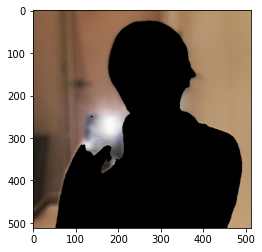

In [16]:
# 흐린 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

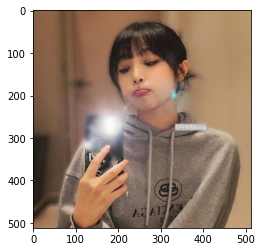

In [17]:
# 처리한 배경과 사람 합체
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 아웃포커스

(853, 1280, 3)


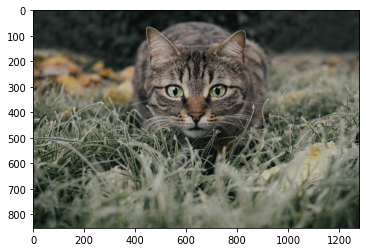

In [18]:
# 이미지 로드
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
cat_img_orig = cv2.imread(cat_img_path) 

print(cat_img_orig.shape)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
cat_model = semantic_segmentation()
cat_model.load_pascalvoc_model(model_file)

In [20]:
cat_segvalues, cat_output = model.segmentAsPascalvoc(cat_img_path)

<function matplotlib.pyplot.show(close=None, block=None)>

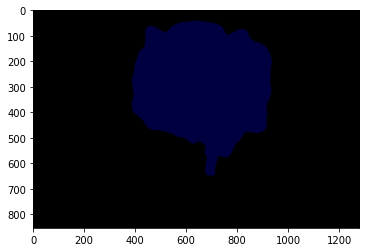

In [21]:
plt.imshow(cat_output)
plt.show

In [22]:
cat_segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in cat_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [24]:
# 물체마다 output에서 어떤 색상이 나타나 있는지 출력
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [25]:
# 고양이을 나타내는 색상 확인
colormap[8]

array([64,  0,  0])

In [26]:
cat_seg_color = (0, 0, 64)

(853, 1280)


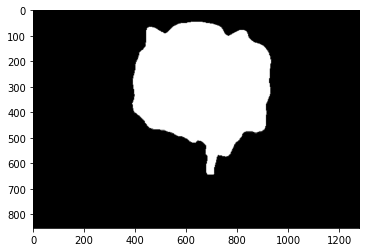

In [27]:
cat_seg_map = np.all(cat_output==cat_seg_color, axis=-1)
print(cat_seg_map.shape)
plt.imshow(cat_seg_map, cmap='gray')
plt.show()

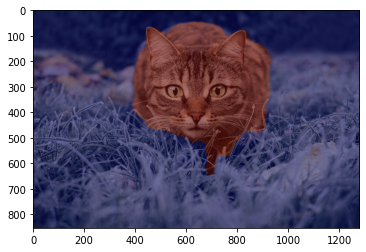

In [28]:
# 원래 이미지와 겹쳐 세그멘테이션을 확인
cat_img_show = cat_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
cat_img_mask = cat_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 결합
# 0.6과 0.4는 두 이미지를 섞는 비율
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

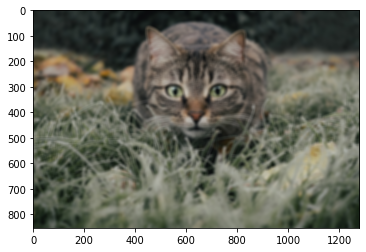

In [29]:
# 배경을 흐리게 변경
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13))  
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

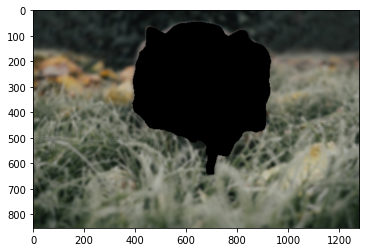

In [30]:
# 흐린 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

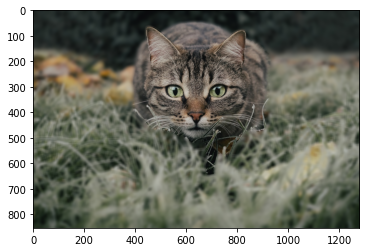

In [31]:
# 처리한 배경과 고양이 합체
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

본래 블러처리 되었었던 상단 배경뿐 아니라 고양이 양옆의 풀도 아웃포커싱 되었다.

### 배경 변경

(1280, 1920, 3)


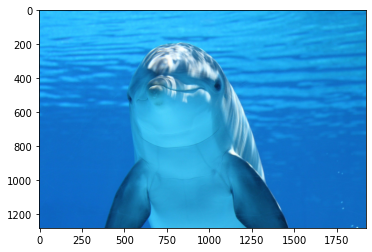

In [46]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dolphin.jpg'  
bg_img_orig = cv2.imread(bg_img_path)

print(bg_img_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

채널 수가 다르면 오류가 발생하므로 사진의 크기를 수정한다.

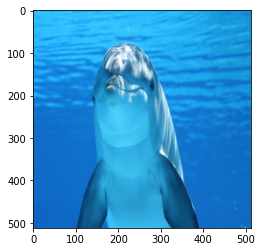

In [50]:
resized_bg = cv2.resize(bg_img_orig, dsize=(512,512), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(resized_bg, cv2.COLOR_BGR2RGB))
plt.show()

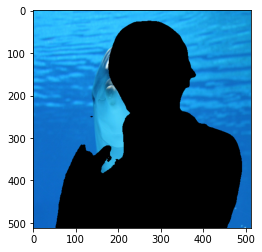

In [51]:
img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(resized_bg, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

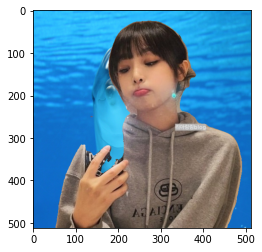

In [52]:
bg_img_concat = np.where(img_mask_color==255, img_orig, resized_bg)
plt.imshow(cv2.cvtColor(bg_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 회고

우선 인물모드와 크로마키를 이용해 배경화면을 변경한 경우를 비교해보자.

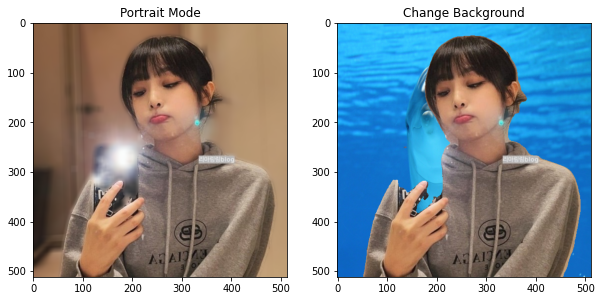

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax[0].set_title("Portrait Mode")

ax[1].imshow(cv2.cvtColor(bg_img_concat, cv2.COLOR_BGR2RGB))
ax[1].set_title("Change Background")
plt.show()

오른쪽 사진을 원본과 비교했을 땐 왼쪽 옷과 손은 잘 분리가 되었지만 플래시를 비추는 휴대전화의 경우 배경으로 인식되어 블러처리가 된 것을 제외하면 비교적 배경과 인물이 분리가 잘 되었다고 생각했다. 하지만 배경을 바꿔본 결과, 옷의 채도와 비슷한 배경이 맞닿아 있는 오른쪽의 경우 옷과 배경이 명확하게 분리되지 않았음을 알 수 있었다. 또한 머리카락과 목이 만들고 있는 공간도 정확하게 분리해내지 못했다. 

위와 같은 문제 중 휴대전화가 인식되지 않은 경우는 빛으로 인해 피사체가 불안정해 보였고, PASCAL_VOC에서 분류가 될 라벨이 없기 때문이라고 생각했다. 
배경이 인물 영역에 포함된 경우는 인물과 배경의 색상이 큰 대비를 보이지 않을 때였다. 비슷한 색상의 배경과 인물을 분리하기 위해선 인물과 배경 사이 경계에 있는 그림자를 활용해야한다고 생각한다. 아무리 색상과 채도가 비슷해도 위에 있는 물체의 가장자리에 그림자가 지기 때문에 그 부분을 중점으로 해서 세그멘테이션으로 검출되는 대상을 조절하면 되지 않을까 생각한다.
